# Assignment 3:  Question duplicates

Welcome to the third assignment of course 3. In this assignment you will explore Siamese networks applied to natural language processing. You will further explore the fundamentals of TensorFlow and you will be able to implement a more complicated structure using it. By completing this assignment, you will learn how to implement models with different architectures. 


## Outline

- [Overview](#0)
- [Part 1: Importing the Data](#1)
    - [1.1 Loading in the data](#1.1)
    - [1.2 Learn question encoding](#1.2)
- [Part 2: Defining the Siamese model](#2)
    - [2.1 Understanding the Siamese Network](#2.1)
        - [Exercise 01](#ex01)
    - [2.2 Hard  Negative Mining](#2.2)
        - [Exercise 02](#ex02)
- [Part 3: Training](#3)
    - [3.1 Training the model](#3.1)
        - [Exercise 03](#ex03)
- [Part 4: Evaluation](#4)
    - [4.1 Evaluating your siamese network](#4.1)
    - [4.2 Classify](#4.2)
        - [Exercise 04](#ex04)
- [Part 5: Testing with your own questions](#5)
    - [Exercise 05](#ex05)
- [On Siamese networks](#6)

<a name='0'></a>
### Overview
In particular, in this assignment you will: 

- Learn about Siamese networks
- Understand how the triplet loss works
- Understand how to evaluate accuracy
- Use cosine similarity between the model's outputted vectors
- Use the data generator to get batches of questions
- Predict using your own model


Before getting started take some time to read the following tips: 

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

By now, you should be familiar with Tensorflow and know how to make use of it to define your model. We will start this homework by asking you to create a vocabulary in a similar way as you did in the previous assignments. After this, you will build a classifier that will allow you to identify whether two questions are the same or not. 

<img src = "./img/meme.png" style="width:550px;height:300px;"/>


Your model will take in the two questions, which will be transformed into tensors, each tensor will then go through embeddings, and after that an LSTM. Finally you will compare the outputs of the two subnetworks using cosine similarity. 

Before taking a deep dive into the model, you will start by importing the data set, and exploring it a bit.


###### <a name='1'></a>
# Part 1: Importing the Data
<a name='1.1'></a>
### 1.1 Loading in the data

You will be using the 'Quora question answer' dataset to build a model that can identify similar questions. This is a useful task because you don't want to have several versions of the same question posted. Several times when teaching I end up responding to similar questions on piazza, or on other community forums. This data set has already been labeled for you. Run the cell below to import some of the packages you will be using. 

In [87]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import os
import numpy as np
import pandas as pd
import random as rnd
import tensorflow as tf

# Set random seeds
rnd.seed(34)

In [88]:
import w3_unittest

You will now load the data set. We have done some preprocessing for you. If you have taken the deeplearning specialization, this is a slightly different training method than the one you have seen there. If you have not, then don't worry about it, we will explain everything. 

In [89]:
data = pd.read_csv("questions.csv")
N = len(data)
print('Number of question pairs: ', N)
data.head()

Number of question pairs:  404351


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


First, you will need to split the data into a training and test set. The test set will be used later to evaluate your model.

In [90]:
N_train = 300000
N_test = 10240
data_train = data[:N_train]
data_test = data[N_train:N_train + N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))
del (data)  # remove to free memory

Train set: 300000 Test set: 10240


As explained in the lectures, you will select only the question pairs that are duplicate to train the model. <br>
You need to build two sets of questions as input for the Siamese network, assuming that question $q1_i$ (question $i$ in the first set) is a duplicate of $q2_i$ (question $i$ in the second set), but all other questions in the second set are not duplicates of $q1_i$.  
The test set uses the original pairs of questions and the status describing if the questions are duplicates.

The following cells are in charge of selecting only duplicate questions from the training set, which will give you a smaller dataset. First find the indexes with duplicate questions.

You will start by identifying the indexes in the training set which correspond to duplicate questions. For this you will define a boolean variable `td_index`, which has value `True` if the index corresponds to duplicate questions and `False` otherwise.

In [91]:
td_index = data_train['is_duplicate'] == 1
td_index = [i for i, x in enumerate(td_index) if x]
print('Number of duplicate questions: ', len(td_index))
print('Indexes of first ten duplicate questions:', td_index[:10])

Number of duplicate questions:  111486
Indexes of first ten duplicate questions: [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


You will first need to split the data into a training and test set. The test set will be used later to evaluate your model.

In [92]:
print(data_train['question1'][5])
print(data_train['question2'][5])
print('is_duplicate: ', data_train['is_duplicate'][5])

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
is_duplicate:  1


Next, keep only the rows in the original training set that correspond to the rows where `td_index` is `True`

In [93]:
Q1_train = np.array(data_train['question1'][td_index])
Q2_train = np.array(data_train['question2'][td_index])

Q1_test = np.array(data_test['question1'])
Q2_test = np.array(data_test['question2'])
y_test  = np.array(data_test['is_duplicate'])

<br>Let's print to see what your data looks like.

In [94]:
print('TRAINING QUESTIONS:\n')
print('Question 1: ', Q1_train[0])
print('Question 2: ', Q2_train[0], '\n')
print('Question 1: ', Q1_train[5])
print('Question 2: ', Q2_train[5], '\n')

print('TESTING QUESTIONS:\n')
print('Question 1: ', Q1_test[0])
print('Question 2: ', Q2_test[0], '\n')
print('is_duplicate =', y_test[0], '\n')

TRAINING QUESTIONS:

Question 1:  Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question 2:  I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me? 

Question 1:  What would a Trump presidency mean for current international master’s students on an F1 visa?
Question 2:  How will a Trump presidency affect the students presently in US or planning to study in US? 

TESTING QUESTIONS:

Question 1:  How do I prepare for interviews for cse?
Question 2:  What is the best way to prepare for cse? 

is_duplicate = 0 



Finally, split your training set into training/validation sets so that you can use them at training time.

In [95]:
# Splitting the data
cut_off = int(len(Q1_train) * 0.8)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off:], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111486
The length of the training set is:   89188
The length of the validation set is:  22298


<a name='1.2'></a>
### 1.2 Learning question encoding

The next step is to learn how to encode each of the questions as a list of numbers (integers). You will be learning how to encode each word of the selected duplicate pairs with an index. 

You will start by learning a word dictionary, or vocabulary, containing all the words in your training dataset, which you will use to encode each word of the selected duplicate pairs with an index. 

For this task you will be using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer from Keras. which will take care of everything for you. Begin by setting a seed, so we all get the same encoding.

The vocabulary is learned using the `.adapt()`. This will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them. If you need, you can later access the vocabulary by using `.get_vocabulary()`.

In [96]:
tf.random.set_seed(0)
text_vectorization = tf.keras.layers.TextVectorization(output_mode='int',split='whitespace', standardize='strip_punctuation')
text_vectorization.adapt(np.concatenate((Q1_train,Q2_train)))

As you can see, it is set to split text on whitespaces and it's stripping the punctuation from text. You can check how big your vocabulary is.

In [97]:
print(f'Vocabulary size: {text_vectorization.vocabulary_size()}')

Vocabulary size: 36224


You can also call `text_vectorization` to see what the encoding looks like for the first questions of the training and test datasets

In [98]:
print('first question in the train set:\n')
print(Q1_train[0], '\n') 
print('encoded version:')
print(text_vectorization(Q1_train[0]),'\n')

print('first question in the test set:\n')
print(Q1_test[0], '\n')
print('encoded version:')
print(text_vectorization(Q1_test[0]) )

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
tf.Tensor(
[ 6984     6   178    10  8988  2442 35393   761    13  6636 28205    31
    28   483    45    98], shape=(16,), dtype=int64) 

first question in the test set:

How do I prepare for interviews for cse? 

encoded version:
tf.Tensor([    4     8     6   160    17  2079    17 11775], shape=(8,), dtype=int64)


Expected output:
```
first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
tf.Tensor(
[ 6984     6   178    10  8988  2442 35393   761    13  6636 28205    31
    28   483    45    98], shape=(16,), dtype=int64) 

first question in the test set:

How do I prepare for interviews for cse? 

encoded version:
tf.Tensor([    4     8     6   160    17  2079    17 11775], shape=(8,), dtype=int64)
```

<a name='2'></a>
# Part 2: Defining the Siamese model

<a name='2.1'></a>

### 2.1 Understanding the Siamese Network 
A Siamese network is a neural network which uses the same weights while working in tandem on two different input vectors to compute comparable output vectors. The Siamese network you are about to implement looks something like this:

<img src = "./img/Siamese.png" style="width:790px;height:300px;"/>

You get the question, get it vectorized and embedded, run it through an LSTM layer, normalize $v_1$ and $v_2$, and finally get the corresponding cosine similarity for each pair of questions (remember that each question is a single string). Because of the implementation of the loss function you will see in the next section, you are not going to have the cosine similarity as output of your Siamese network, but rather $v_1$ and $v_2$. You will add the cosine distance step once you reach the classification step. 

To train the model, you will use the triplet loss (explained below). This loss makes use of a baseline (anchor) input that is compared to a positive (truthy) input and a negative (falsy) input. The (cosine) distance from the baseline input to the positive input is minimized, and the distance from the baseline input to the negative  input is maximized. Mathematically, you are trying to maximize the following.

$$\mathcal{L}(A, P, N)=\max \left(\|\mathrm{f}(A)-\mathrm{f}(P)\|^{2}-\|\mathrm{f}(A)-\mathrm{f}(N)\|^{2}+\alpha, 0\right),$$

where $A$ is the anchor input, for example $q1_1$, $P$ is the duplicate input, for example, $q2_1$, and $N$ is the negative input (the non duplicate question), for example $q2_2$.<br>
$\alpha$ is a margin; you can think about it as a safety net, or by how much you want to push the duplicates from the non duplicates. This is the essence of the triplet loss. However, as you will see in the next section, you will be using a pretty smart trick to improve your training, known as hard negative mining. 
<br>

<a name='ex02'></a>
### Exercise 01

**Instructions:** Implement the `Siamese` function below. You should be using all the functions explained below. 

To implement this model, you will be using `TensorFlow`. Concretely, you will be using the following functions.


- [`tf.keras.models.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential): groups a linear stack of layers into a tf.keras.Model.
    - You can pass in the layers as arguments to `Serial`, separated by commas, or simply instantiate the `Sequential`model and use the `add` method to add layers.
    - For example: `Sequential(Embeddings(...), AveragePooling1D(...), Dense(...), Softmax(...))` or 
    
    `model = Sequential()
     model.add(Embeddings(...))
     model.add(AveragePooling1D(...))
     model.add(Dense(...))
     model.add(Softmax(...))`

-  [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) : Maps positive integers into vectors of fixed size. It will have shape (vocabulary length X dimension of output vectors). The dimension of output vectors (called `d_feature`in the model) is the number of elements in the word embedding. 
    - `Embedding(input_dim, output_dim)`.
    - `input_dim` is the number of unique words in the given vocabulary.
    - `output_dim` is the number of elements in the word embedding (some choices for a word embedding size range from 150 to 300, for example).
    


-  [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) : The LSTM layer. The number of units should be specified and should match the number of elements in the word embedding. 
    - `LSTM(units)` Builds an LSTM layer of n_units.
    
    
    
- [`tf.keras.layers.GlobalAveragePooling1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) : Computes global average pooling, which essentially takes the mean across a desired axis. GlobalAveragePooling1D uses one tensor axis to form groups of values and replaces each group with the mean value of that group. 
    - `GlobalAveragePooling1D()` takes the mean.



- [`tf.keras.layers.Lambda`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn): Layer with no weights that applies the function f, which should be specified using a lambda syntax. You will use this layer to apply normalization with the function
    - `tfmath.l2_normalize(x)`



- [`tf.keras.layers.Input`](https://www.tensorflow.org/api_docs/python/tf/keras/Input): it is used to instantiate a Keras tensor. Remember to set correctly the dimension and type of the input, which are batches of questions. For this, keep in mind that each question is a single string. 
    - `Input(input_shape,dtype=None,...)`
    - `input_shape`: Shape tuple (not including the batch axis)
    - `dtype`: (optional) data type of the input



- [`tf.keras.layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate): Layer that concatenates a list of inputs. This layer will concatenate the normalized outputs of each LSTM into a single output for the model. 
    - `Concatenate()`

In [99]:
# GRADED FUNCTION: Siamese
def Siamese(text_vectorizer, vocab_size=36224, d_feature=128):
    """Returns a Siamese model.

    Args:
        text_vectorizer (TextVectorization): TextVectorization instance, already adapted to your training data.
        vocab_size (int, optional): Length of the vocabulary. Defaults to 36224, which is the vocabulary size for your case.
        d_model (int, optional): Depth of the model. Defaults to 128.
        
    Returns:
        tf.model.Model: A Siamese model. 
    
    """
    ### START CODE HERE ###

    branch = tf.keras.models.Sequential(name='sequential') 
    # Add the text_vectorizer layer. This is the text_vectorizer you instantiated and trained before 
    branch.add(text_vectorizer)
    # Add the Embedding layer. Remember to call it 'embedding' using the parameter `name`
    branch.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_feature, name='embedding'))
    # Add the LSTM layer, recall from W2 that you want to the LSTM layer to return sequences, ot just one value. 
    # Remember to call it 'LSTM' using the parameter `name`
    branch.add(tf.keras.layers.LSTM(units=d_feature, return_sequences=True, name='LSTM'))
    # Add the GlobalAveragePooling1D layer. Remember to call it 'mean' using the parameter `name`
    branch.add(tf.keras.layers.GlobalAveragePooling1D(name='mean'))
    # Add the normalizing layer using the Lambda function. Remember to call it 'out' using the parameter `name`
    branch.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='out'))
    
    # Define both inputs. Remember to call then 'input_1' and 'input_2' using the `name` parameter. 
    # Be mindful of the data type and size
    input1 = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_1')
    input2 = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_2')
    # Define the output of each branch of your Siamese network. Remember that both branches have the same coefficients, 
    # but they each receive different inputs.
    branch1 = branch(input1)
    branch2 = branch(input2)
    # Define the Concatenate layer. You should concatenate columns, you can fix this using the `axis`parameter. 
    # This layer is applied over the outputs of each branch of the Siamese network
    conc = tf.keras.layers.Concatenate(axis=-1, name='conc_1_2')([branch1, branch2]) 
    
    ### END CODE HERE ###
    
    return tf.keras.models.Model(inputs=[input1, input2], outputs=conc, name="SiameseModel")

Setup the Siamese network model

In [100]:
# check your model
model = Siamese(text_vectorization, vocab_size=text_vectorization.vocabulary_size())
model.build(input_shape=None)
model.summary()
model.get_layer(name='sequential').summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  4768256   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conc_1_2 (Concatenate)      (None, 256)                  0         ['sequential[0][0]'

**Expected output:**  

<font size=2>

```Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
==================================================================================================
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  4768256   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conc_1_2 (Concatenate)      (None, 256)                  0         ['sequential[0][0]',          
                                                                     'sequential[1][0]']          
                                                                                                  
==================================================================================================
Total params: 4768256 (18.19 MB)
Trainable params: 4768256 (18.19 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         4636672   
                                                                 
 LSTM (LSTM)                 (None, None, 128)         131584    
                                                                 
 mean (GlobalAveragePooling  (None, 128)               0         
 1D)                                                             
                                                                 
 out (Lambda)                (None, 128)               0         
                                                                 
=================================================================
Total params: 4768256 (18.19 MB)
Trainable params: 4768256 (18.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
```
</font>

You can also draw the model for a clearer view of your Siamese network

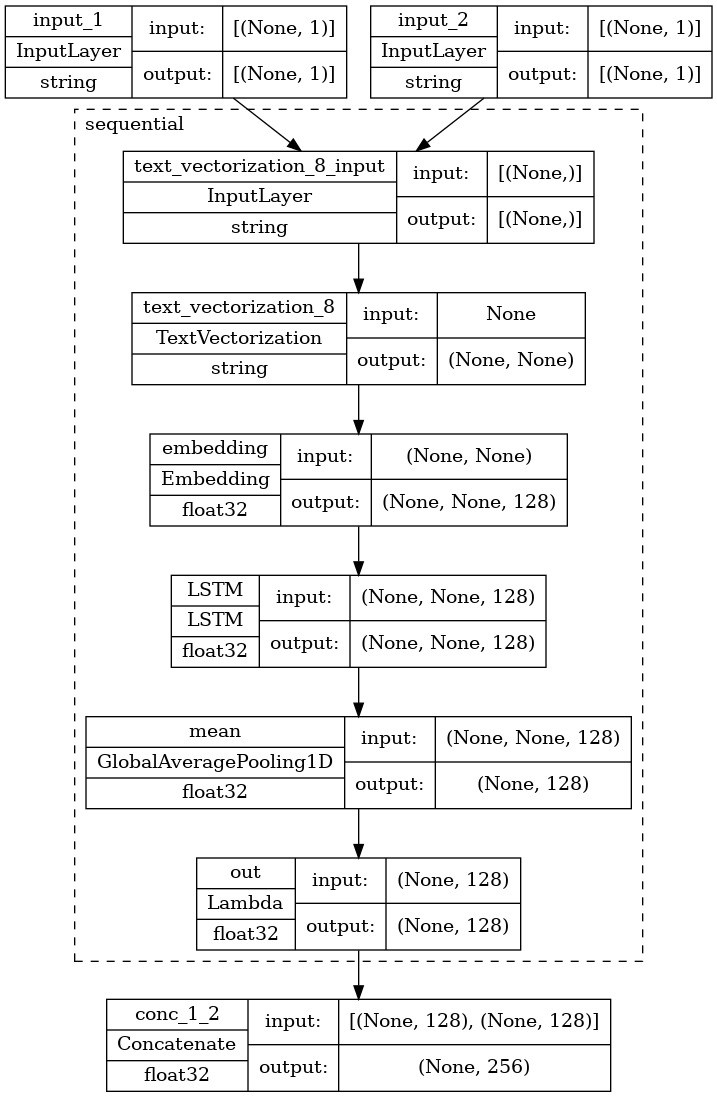

In [101]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True)

In [102]:
# Test your function!
w3_unittest.test_Siamese(Siamese)

All tests passed!


<a name='2.2'></a>

### 2.2 Hard Negative Mining


You will now implement the `TripletLoss` with hard negative mining.<br>
As explained in the lecture, you will be using all the questions from each batch to compute this loss. Positive examples are questions $q1_i$, and $q2_i$, while all the other combinations $q1_i$, $q2_j$ ($i\neq j$), are considered negative examples. The loss will be composed of two terms. One term utilizes the mean of all the non duplicates, the second utilizes the *closest negative*. Our loss expression is then:
 
\begin{align}
 \mathcal{Loss_1(A,P,N)} &=\max \left( -cos(A,P)  + mean_{neg} +\alpha, 0\right) \\
 \mathcal{Loss_2(A,P,N)} &=\max \left( -cos(A,P)  + closest_{neg} +\alpha, 0\right) \\
\mathcal{Loss(A,P,N)} &= mean(Loss_1 + Loss_2) \\
\end{align}


Further, two sets of instructions are provided. The first set, found just below, provides a brief description of the task. If that set proves insufficient, a more detailed set can be displayed.  

<a name='ex03'></a>
### Exercise 02

**Instructions (Brief):** Here is a list of things you should do: <br>

- As this will be run inside Tensorflow, use all operation supplied by `tf.math` or `tf.linalg`, instead of `numpy` functions. You will also need to explicitly use `tf.shape` to get the batch size from the inputs. This is to make it compatible with the Tensor inputs it will receive when doing actual training and testing. 
- Use [`tf.linalg.matmul`](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) to calculate the similarity matrix $v_2v_1^T$ of dimension `batch_size` x `batch_size`. 
- Take the score of the duplicates on the diagonal with [`tf.linalg.diag_part`](https://www.tensorflow.org/api_docs/python/tf/linalg/diag_part). 
- Use the `TensorFlow` functions [`tf.eye`](https://www.tensorflow.org/api_docs/python/tf/eye) and [`tf.math.reduce_max`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_max) for the identity matrix and the maximum respectively. 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>More Detailed Instructions </b></font>
</summary>

We'll describe the algorithm using a detailed example. Below, $V_1$, $V_2$ are the output of the normalization blocks in our model. Here you will use a `batch_size` of 4 and a `d_model of 3`. As explained in lecture, the input questions, Q1, Q2 are arranged so that corresponding inputs are duplicates while non-corresponding entries are not. The outputs will have the same pattern.

<img src = "./img/tripletLossexample.png" style="width:817px;"/>

This testcase arranges the outputs, $V_1$,$V_2$, to highlight different scenarios. Here, the first two outputs $V_1[0]$, $V_2[0]$ match exactly, so the model is generating the same vector for Q1[0] and Q2[0] inputs. The second pair of outputs, circled in orange, differ greatly on one of the values, so the transformation is not quite the same for these questions. Next, you have examples $V_1[3]$ and $V_2[3]$, which match almost exactly. Finally, $V_1[4]$ and $V_2[4]$, circled in purple, are set to be exactly opposite, being 180 degrees from each other. 

The first step is to compute the cosine similarity matrix or `score` in the code. As explained in the lectures, this is $$V_2 V_1^T.$$This is generated with `tf.linalg.matmul`. Since matrix multiplication is not commutative, the order in which you pass the arguments is important. If you want columns to represent different questions in Q1 and rows to represent different questions in Q2, as seen in the video, then you need to compute $V_2 V_1^T$. 

<img src = "./img/tripletLoss2.png" style="width:900px;"/>

The clever arrangement of inputs creates the data needed for positive *and* negative examples without having to run all pair-wise combinations. Because Q1[n] is a duplicate of only Q2[n], other combinations are explicitly created negative examples or *Hard Negative* examples. The matrix multiplication efficiently produces the cosine similarity of all positive/negative combinations as shown above on the left side of the diagram. 'Positive' are the results of duplicate examples (cells shaded in green) and 'negative' are the results of explicitly created negative examples (cells shaded in blue). The results for our test case are as expected, $V_1[0]\cdot V_2[0]$ and $V_1[3]\cdot V_2[3]$ match producing '1', and '0.99' respectively, while the other 'positive' cases don't match quite right. Note also that the $V_2[2]$ example was set to match $V_1[3]$, producing a not so good match at `score[2,2]` and an undesired 'negative' case of a '1', shown in grey. 

With the similarity matrix (`score`) you can begin to implement the loss equations. First, you can extract $cos(A,P)$ by utilizing `tf.linalg.diag_part`. The goal is to grab all the green entries in the diagram above. This is `positive` in the code.

Next, you will create the *closest_negative*. This is the nonduplicate entry in $V_2$ that is closest to (has largest cosine similarity) to an entry in $V_1$, but still has smaller cosine similarity than the positive example. For example, consider row 2 in the score matrix. This row has the cosine similarity between $V_2[2]$ and all four vectors in $V_1$. In this case, the largest value in the off-diagonal is`score[2,3]`$=V_2[3]\cdot V1[2]$, which has a score of 1. However, since 1 is grater than the similarity for the positive example, this is *not* the *closest_negative*. For this particular row, the *closes_negative* will have to be `score[2,1]=0.36`. This is the maximum value of the 'negative' entries, which are smaller than the 'positive' example.

To implement this, you need to pick the maximum entry on a row of `score`, ignoring the 'positive'/green entries, and 'negative/blue entry greater that the 'positive' one. To avoid selecting these entries, you can make them larger negative numbers. For this, you can create a mask to identify these two scenarios, multiply it by 2.0 and subtract it out of `scores`. To create the mask, you need to check if the cell is diagonal by computing `tf.eye(batch_size) ==1`, or if the non-diagonal cell is greater than the diagonal with `(negative_zero_on_duplicate > tf.expand_dims(positive, 1)`. Remember that `positive` already has the diagonal values. Now you can use `tf.math.reduce_max`, row by row (axis=1), to select the maximum which is `closest_negative`.

Next, we'll create *mean_negative*. As the name suggests, this is the mean of all the 'negative'/blue values in `score` on a row by row basis. You can use `tf.linalg.diag` to create a diagonal matrix, where the diagonal matches `positive`, and just subtract it from `score` to get just the 'negative' values. This is `negative_zero_on_duplicate` in the code. Compute the mean by using `tf.math.reduce_sum` on `negative_zero_on_duplicate` for `axis=1` and divide it by `(batch_size - 1)`. This is `mean_negative`.

Now, you can compute loss using the two equations above and `tf.maximum`. This will form `triplet_loss1` and `triplet_loss2`. 

`triplet_loss` is the `tf.math.reduce_sum` of the sum of the two individual losses.


In [153]:
# GRADED FUNCTION: TripletLossFn
def TripletLossFn(v1, v2,  margin=0.25):
    """Custom Loss function.

    Args:
        v1 (numpy.ndarray or Tensor): Array with dimension (batch_size, model_dimension) associated to Q1.
        v2 (numpy.ndarray or Tensor): Array with dimension (batch_size, model_dimension) associated to Q2.
        margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
        triplet_loss (numpy.ndarray or Tensor)
    """
   
    ### START CODE HERE ###

    # use `tf.linalg.matmul` to take the dot product of the two batches. 
    # Don't forget to transpose the second argument using `transpose_b=True`
    scores = tf.linalg.matmul(v2, v1, transpose_b=True)
    # calculate new batch size and cast it as the same datatype as scores. 

    batch_size = tf.cast(tf.shape(v1)[0], scores.dtype) 
    # use `tf.linalg.diag_part` to grab the cosine similarity of all positive examples
    positive = tf.linalg.diag_part(scores)
    # subtract the diagonal from scores. You can do this by creating a diagonal matrix with the values 
    # of all positive examples using `tf.linalg.diag`
    negative_zero_on_duplicate = scores - tf.linalg.diag(positive)
    # use `tf.math.reduce_sum` on `negative_zero_on_duplicate` for `axis=1` and divide it by `(batch_size - 1)`
    mean_negative = tf.math.reduce_sum(negative_zero_on_duplicate, axis=1) / (batch_size - 1)
    # create a composition of two masks: 
    # the first mask to extract the diagonal elements (make sure you use the variable batch_size here), 
    # the second mask to extract elements in the negative_zero_on_duplicate matrix that are larger than the elements in the diagonal 
    mask_exclude_positives = tf.cast((tf.eye(batch_size) == 1)|(negative_zero_on_duplicate > tf.expand_dims(positive, 1)),
                                    scores.dtype)
    # multiply `mask_exclude_positives` with 2.0 and subtract it out of `negative_zero_on_duplicate`
    negative_without_positive = negative_zero_on_duplicate - 2.0 * mask_exclude_positives
    # take the row by row `max` of `negative_without_positive`. 
    # Hint: `tf.math.reduce_max(negative_without_positive, axis = None)`
    closest_negative = tf.math.reduce_max(negative_without_positive, axis=-1)
    # compute `tf.maximum` among 0.0 and `A`
    # A = subtract `positive` from `margin` and add `closest_negative` 
    triplet_loss1 = tf.maximum(0.0, margin - positive + closest_negative)
    # compute `tf.maximum` among 0.0 and `B`
    # B = subtract `positive` from `margin` and add `mean_negative` 
    triplet_loss2 = tf.maximum(0.0, margin - positive + mean_negative)
    # add the two losses together and take the `tf.math.reduce_sum` of it
    triplet_loss = tf.math.reduce_sum(triplet_loss1 + triplet_loss2)
    
    ### END CODE HERE ###

    return triplet_loss

Now you can check the triplet loss between two sets. The following example emulates the triplet loss between two groups of questions with `batch_size=2`

In [154]:
v1 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
v2 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
print("Triplet Loss:", TripletLossFn(v1,v2).numpy())

Triplet Loss: 0.703507682515891


**Expected Output:**
```CPP
Triplet Loss: ~ 0.70
```   

To recognize it as a loss function, keras needs it to have two inputs: true labels, and output labels. You will not be using the true labels, but you still need to pass some dummy variable with size `(batch_size,)` for TensorFlow to accept it as a valid loss.

Additionally, the `out` parameter must coincide with the output of your Siamese network, which is the concatenation of the processing of each of the inputs, so you need to extract $v_1$ and $v_2$ from there.

In [151]:
def TripletLoss(labels, out, margin=0.25):
    _, out_size = out.shape # get embedding size
    v1 = out[:,:int(out_size/2)] # Extract v1 from out
    v2 = out[:,int(out_size/2):] # Extract v2 from out
    return TripletLossFn(v1, v2, margin=margin)

In [152]:
# Test your function!
w3_unittest.test_TripletLoss(TripletLoss)

All tests passed!


<a name='3'></a>

# Part 3: Training

Now it's time to finally train your model. As usual, you have to define the cost function and the optimizer. You also have to build the actual model you will be training. 

To pass the input questions for training and validation you will use the iterator produced by [`tensorflow.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Run the next cell to create your train and validation datasets. 

In [156]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_Q1, train_Q2),tf.constant([1]*len(train_Q1))))
val_dataset = tf.data.Dataset.from_tensor_slices(((val_Q1, val_Q2),tf.constant([1]*len(val_Q1))))

<a name='3.1'></a>

### 3.1 Training the model

You will now write a function that takes in your model to train it. To train your model you have to decide how many times you want to iterate over the entire data set; each iteration is defined as an `epoch`. For each epoch, you have to go over all the data, using your `Dataset` iterator.

<a name='ex04'></a>
### Exercise 03

**Instructions:** Implement the `train_model` below to train the neural network above. Here is a list of things you should do: 

- Compile the model. Here you will need to pass in:
    - `loss=TripletLoss`
    - `optimizer=Adam()` with learning rate `lr`
- Call the `fit` method. You should pass:
    - `train_dataset`
    - `epochs`
    - `validation_data` 



You will be using your triplet loss function with Adam optimizer. Also, note that you are not explicitly defining the batch size, because it will be already determined by the `Dataset`.

This function will return the trained model

In [185]:
# GRADED FUNCTION: train_model
def train_model(Siamese, TripletLoss, text_vectorizer, train_dataset, val_dataset, d_feature=128, lr=0.01, train_steps=5):
    """Training the Siamese Model

    Args:
        Siamese (function): Function that returns the Siamese model.
        TripletLoss (function): Function that defines the TripletLoss loss function.
        text_vectorizer: trained instance of `TextVecotrization` 
        train_dataset (tf.data.Dataset): Training dataset
        val_dataset (tf.data.Dataset): Validation dataset
        d_feature (int, optional) = size of the encoding. Defaults to 128.
        lr (float, optional): learning rate for optimizer. Defaults to 0.01
        train_steps (int): number of epochs
        
    Returns:
        tf.keras.Model
    """
    ## START CODE HERE ###

    # Instantiate your Siamese model
    model = Siamese(text_vectorizer,
                    vocab_size = text_vectorizer.vocabulary_size(), #set vocab_size accordingly to the size of your vocabulary
                    d_feature = d_feature)
    # Compile the model
    model.compile(loss=TripletLoss,
                  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            )
    # Train the model 
    model.fit(train_dataset,
              epochs = train_steps,
              validation_data = val_dataset,
             )
             
    ### END CODE HERE ###

    return model

Now call the `train_model` function. You will be using a batch size of 256. 

To create the data generators you will be using the method `batch` for `Dataset` object. You will also call the `shuffle` method, to shuffle the dataset on each iteration.

In [186]:
train_steps = 2
batch_size = 256
train_generator = train_dataset.shuffle(len(train_Q1),
                                        seed=7, 
                                        reshuffle_each_iteration=True).batch(batch_size=batch_size)
val_generator = val_dataset.shuffle(len(val_Q1), 
                                   seed=7,
                                   reshuffle_each_iteration=True).batch(batch_size=batch_size)
model = train_model(Siamese, TripletLoss,text_vectorization, 
                                            train_generator, 
                                            val_generator, 
                                            train_steps=train_steps,)

Epoch 1/2
349/349 [==============================] - 26s 68ms/step - loss: 30.4959 - val_loss: 12.4318
Epoch 2/2
349/349 [==============================] - 9s 24ms/step - loss: 8.6241 - val_loss: 9.4517


The model was only trained for 2 steps because training the whole Siamese network takes too long, and produces slightly different results for each run. For the rest of the assignment you will be using a pretrained model, but this small example should help you understand how the training can be done.

In [187]:
# Test your function!
w3_unittest.test_train_model(train_model, Siamese, TripletLoss)

All tests passed!


<a name='4'></a>

# Part 4:  Evaluation  

<a name='4.1'></a>

### 4.1 Evaluating your siamese network

In this section you will learn how to evaluate a Siamese network. You will start by loading a pretrained model, and then you will use it to predict. For the prediction you will need to take the output of your model and compute the cosine loss between each pair of questions.

In [188]:
model = tf.keras.models.load_model('model/trained_model.keras', safe_mode=False, compile=False)

# Show the model architecture
model.summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  4768256   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conc_1_2 (Concatenate)      (None, 256)                  0         ['sequential[0][0]'

<a name='4.2'></a>
### 4.2 Classify
To determine the accuracy of the model, you will use the test set that was configured earlier. While in training you used only positive examples, the test data, `Q1_test`, `Q2_test` and `y_test`, is set up as pairs of questions, some of which are duplicates and some are not. 
This routine will run all the test question pairs through the model, compute the cosine similarity of each pair, threshold it and compare the result to `y_test` - the correct response from the data set. The results are accumulated to produce an accuracy; the confusion matrix is also computed to have a better understanding of the errors.


<a name='ex05'></a>
### Exercise 04

**Instructions**  
 - Use a `tensorflow.data.Dataset` to go through the data in chunks with size batch_size. This time you don't need the labels, so you can just replace them by `None`,
 - use `predict` on the chunks of data.
 - compute `v1`, `v2` using the model output,
 - for each element of the batch
        - compute the cosine similarity of each pair of entries, `v1[j]`,`v2[j]`
        - determine if `d > threshold`
        - increment accuracy if that result matches the expected results (`y_test[j]`)
  
   Instead of running a for loop, you will vectorize all these operations to make things more efficient,
 - compute the final accuracy and confusion matrix and return. For the confusion matrix you can use the [`tf.math.confusion_matrix`](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix) function. 

In [231]:
# GRADED FUNCTION: classify
def classify(test_Q1, test_Q2, y_test, threshold, model, batch_size=64, verbose=True):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions. Each element of the array would be a string.
        test_Q2 (numpy.ndarray): Array of Q2 questions. Each element of the array would be a string.
        y_test (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold
        model (tensorflow.Keras.Model): The Siamese model.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model
        numpy.array: confusion matrix
    """
    y_pred = []
    test_gen = tf.data.Dataset.from_tensor_slices(((test_Q1, test_Q2),None)).batch(batch_size=batch_size)
    
    ### START CODE HERE ###

    pred = model.predict(test_gen)
    _, n_feat = model.output_shape 

    v1 = pred[:, : n_feat // 2]
    v2 = pred[:, n_feat // 2 : ]
    
    # Compute the cosine similarity. Using `tf.math.reduce_sum`. 
    # Don't forget to use the appropriate axis argument.
    d  = tf.reduce_sum(v1 * v2, axis=1)
    # Check if d>threshold to make predictions
    y_pred = tf.cast(d > threshold, tf.float64)
    # take the average of correct predictions to get the accuracy
    accuracy = tf.reduce_mean(tf.cast(y_pred == y_test, tf.float64))
    # compute the confusion matrix using `tf.math.confusion_matrix`
    cm = tf.math.confusion_matrix(y_test, y_pred)
    
    ### END CODE HERE ###
    
    return accuracy, cm

In [232]:
# this takes around 1 minute
accuracy, cm = classify(Q1_test,Q2_test, y_test, 0.7, model,  batch_size = 512) 
print("Accuracy", accuracy.numpy())
print(f"Confusion matrix:\n{cm.numpy()}")

20/20 [==============================] - 0s 5ms/step
Accuracy 0.7259765625
Confusion matrix:
[[4876 1506]
 [1300 2558]]


### **Expected Result**  
Accuracy ~0.725

Confusion matrix:
```
[[4876 1506]
 [1300 2558]]
 ```

In [233]:
# Test your function!
w3_unittest.test_classify(classify, model)

14/14 [==============================] - 0s 4ms/step
All tests passed!


<a name='5'></a>

# Part 5: Testing with your own questions

In this final section you will test the model with your own questions. You will write a function `predict` which takes two questions as input and returns `True` or `False` depending on whether the question pair is a duplicate or not.   

Write a function `predict` that takes in two questions, the threshold and the model, and returns whether the questions are duplicates (`True`) or not duplicates (`False`) given a similarity threshold. 

<a name='ex06'></a>
### Exercise 05


**Instructions:** 
- Create a tensorflow.data.Dataset from your two questions. Again, labels are not important, so you simply write `None`
- use the trained model output to create `v1`, `v2`
- compute the cosine similarity (dot product) of `v1`, `v2`
- compute `res` by comparing d to the threshold


In [238]:
# GRADED FUNCTION: predict
def predict(question1, question2, threshold, model, verbose=False):
    """Function for predicting if two questions are duplicates.

    Args:
        question1 (str): First question.
        question2 (str): Second question.
        threshold (float): Desired threshold.
        model (tensorflow.keras.Model): The Siamese model.
        verbose (bool, optional): If the results should be printed out. Defaults to False.

    Returns:
        bool: True if the questions are duplicates, False otherwise.
    """
    generator = tf.data.Dataset.from_tensor_slices((([question1], [question2]),None)).batch(batch_size=1)
    
    ### START CODE HERE ###
    
    # Call the predict method of your model and save the output into v1v2
    v1v2 = model.predict(generator)
    # Extract v1 and v2 from the model output
    v1 = v1v2[:, : v1v2.shape[1] // 2]
    v2 = v1v2[:, v1v2.shape[1] // 2 :]
    # Take the dot product to compute cos similarity of each pair of entries, v1, v2
    # Since v1 and v2 are both vectors, use the function tf.math.reduce_sum instead of tf.linalg.matmul
    d = tf.reduce_sum(v1 * v2, axis=1)
    # Is d greater than the threshold?
    res = tf.cast(d > threshold, tf.bool)

    ### END CODE HERE ###
    
    if(verbose):
        print("Q1  = ", question1, "\nQ2  = ", question2)
        print("d   = ", d.numpy())
        print("res = ", res.numpy())

    return res.numpy()

In [239]:
# Feel free to try with your own questions
question1 = "When will I see you?"
question2 = "When can I see you again?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, verbose = True)

1/1 [==============================] - 0s 13ms/step
Q1  =  When will I see you? 
Q2  =  When can I see you again?
d   =  [0.8422112]
res =  [ True]


array([ True])

##### Expected Output
If input is:
```
question1 = "When will I see you?"
question2 = "When can I see you again?"
```

Output is (d may vary a bit):
```
1/1 [==============================] - 0s 13ms/step
Q1  =  When will I see you? 
Q2  =  When can I see you again?
d   =  0.8422112
res =  True
```

In [240]:
# Feel free to try with your own questions
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, verbose=True)

1/1 [==============================] - 0s 12ms/step
Q1  =  Do they enjoy eating the dessert? 
Q2  =  Do they like hiking in the desert?
d   =  [0.12625802]
res =  [False]


array([False])

##### Expected output

If input is:
```
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
```

Output (d may vary a bit):

```
1/1 [==============================] - 0s 12ms/step
Q1  =  Do they enjoy eating the dessert? 
Q2  =  Do they like hiking in the desert?
d   =  0.12625802
res =  False

False
```

You can see that the Siamese network is capable of catching complicated structures. Concretely it can identify question duplicates although the questions do not have many words in common. 
 

In [241]:
# Test your function!
w3_unittest.test_predict(predict, model)

1/1 [==============================] - 0s 12ms/step
All tests passed!


<a name='6'></a>

### On Siamese networks

Siamese networks are important and useful. Many times there are several questions that are already asked in quora, or other platforms and you can use Siamese networks to avoid question duplicates. 

Congratulations, you have now built a powerful system that can recognize question duplicates. In the next course we will use transformers for machine translation, summarization, question answering, and chatbots. 


# 